In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm

import torch
from torchvision import datasets, transforms

In [15]:
def type_it(check):
    print(type(check))
    if isinstance(check, torch.Tensor):
        print(check.size())
    return

def plot_image(image_tensor):
    # Check if the tensor has 3 channels
    if image_tensor.shape[0] == 3:
        image_np = image_tensor.permute(1, 2, 0).numpy()
        plt.imshow(image_np)
    else:
        image_np = image_tensor.numpy()
        plt.imshow(image_np, cmap='gray')
    
    plt.figure(figsize=(1, 1))
    plt.show()

In [43]:
def plot_first_100_images_with_labels(tensor, labels):
    # Ensure tensor is a numpy array
    if not isinstance(tensor, np.ndarray):
        tensor = tensor.numpy()
    
    if tensor.ndim == 4:  # 3-channel images
        channels = tensor.shape[1]
    elif tensor.ndim == 3:  # 1-channel images
        channels = 1
    else:
        raise ValueError("Tensor must be either 3 or 4 dimensions")
    
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))  # Create a 10x10 grid for the first 100 images
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(100):
        ax = axes[i // 10, i % 10]
        if channels == 1:  # 1-channel image
            img = tensor[i]
            ax.imshow(img, cmap='gray')
        else:  # 3-channel image
            img = tensor[i]
            img = np.transpose(img, (1, 2, 0))  # Move the channel to the last dimension for displaying
            ax.imshow(img)
        
        ax.axis('off')  # Turn off the axis
        ax.set_title(labels[i], fontsize=8)  # Set the title to the label

    plt.show()

# Example usage:
# Assuming `tensor` is your 4D tensor of shape [6000, 3, 28, 28] or 3D tensor of shape [6000, 28, 28]
# and `labels` is a list of length 6000
# plot_first_100_images_with_labels(tensor, labels)

In [86]:
def load_full_datasets(
    dataset_name: str = "MNIST",
) -> list:
    '''
    Load datasets into four separate parts: train labels, train images, test labels, test images.

    Args:
        dataset_name (str): Name of the dataset to load. Options are "MNIST", "FMNIST", "EMNIST", "CIFAR10", "CIFAR100".

    TODO: EMNIST IS NOT WELL.

    Returns:
        list: [4].
    '''
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "EMNIST": # not auto-downloaded successfully
        train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, 
                                            transform = transforms.Compose([ 
                                            lambda img: transforms.functional.rotate(img, -90), 
                                            lambda img: transforms.functional.hflip(img), 
                                            transforms.ToTensor()
                                            ])
                                        )               
        test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True,
                                            transform = transforms.Compose([ 
                                            lambda img: transforms.functional.rotate(img, -90), 
                                            lambda img: transforms.functional.hflip(img), 
                                            transforms.ToTensor()
                                            ])
                                        )         
    elif dataset_name == "CIFAR10":
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR100":
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Dataset {dataset_name} is not supported.")

    # Extracting train and test images and labels
    train_images = torch.stack([data[0] for data in train_dataset]).squeeze(1)
    test_images = torch.stack([data[0] for data in test_dataset]).squeeze(1)
    
    if dataset_name in ["CIFAR10", "CIFAR100"]:
        train_labels = torch.tensor(train_dataset.targets).clone().detach()
        test_labels = torch.tensor(test_dataset.targets).clone().detach()
    else:
        train_labels = train_dataset.targets.clone().detach()
        test_labels = test_dataset.targets.clone().detach()

    return [train_images, train_labels, test_images, test_labels]

In [3]:
def rotate_dataset(
    dataset: torch.Tensor,
    degrees: list
) -> torch.Tensor:
    '''
    Rotates all images in the dataset by a specified degree.

    Args:
        dataset (torch.Tensor): Input dataset, a tensor of shape (N, H, W) where N is the number of images.
        degrees (list) : List of degrees to rotate each image.

    Returns:
        torch.Tensor: The rotated dataset, a tensor of the same shape (N, H, W) as the input.
    '''

    if len(dataset) != len(degrees):
        raise ValueError("The length of degrees list must be equal to the number of images in the dataset.")
    
    rotated_images = []
    
    for img_tensor, degree in zip(dataset, degrees):
        # Convert the tensor to a PIL image
        img = transforms.ToPILImage()(img_tensor)
        
        # Rotate the image
        rotated_img = img.rotate(degree)
        
        # Convert the PIL image back to a tensor
        rotated_img_tensor = transforms.ToTensor()(rotated_img).squeeze(0)
        
        rotated_images.append(rotated_img_tensor)
    
    # Stack all tensors into a single tensor
    rotated_dataset = torch.stack(rotated_images)
    
    return rotated_dataset

In [4]:
def color_dataset(
        dataset: torch.Tensor,
        colors: list
    ) -> torch.Tensor:
    '''
    Colors all images in the dataset by a specified color.

    Args:
        dataset (torch.Tensor): Input dataset, a tensor of shape (N, H, W) or (N, 3, H, W)
                                where N is the number of images.
        colors (list) : List of 'red', 'green', 'blue'.

    Warning:
        MNIST, FMNIST, EMNIST are 1-channel. CIFAR10, CIFAR100 are 3-channel.

    Returns:
        torch.Tensor: The colored dataset, a tensor of the shape (N, 3, H, W) with 3 channels.
    '''

    if len(dataset) != len(colors):
        raise ValueError("The length of colors list must be equal to the number of images in the dataset.")

    if dataset.dim() == 3:
        # Handle 1-channel dataset
        colored_dataset = dataset.unsqueeze(1).repeat(1, 3, 1, 1) # Shape becomes (N, 3, H, W)
    elif dataset.dim() == 4 and dataset.size(1) == 3:
        colored_dataset = dataset.clone()
    else:
        raise ValueError("This function only supports 1-channel (N, H, W) or 3-channel (N, 3, H, W) datasets.")

    for i, color in enumerate(colors):
        # Map the grayscale values to the specified color
        if color == 'red':
            colored_dataset[i, 0, :, :] = 1  # Set the red channel for the image
        elif color == 'green':
            colored_dataset[i, 1, :, :] = 1  # Set the green channel for the image
        elif color == 'blue':
            colored_dataset[i, 2, :, :] = 1  # Set the blue channel for the image
        else:
            raise ValueError("Color must be 'red', 'green', or 'blue'")

    return colored_dataset

In [5]:
def split_basic(
    features: torch.Tensor,
    labels: torch.Tensor,
    client_number: int = 10,
    permute: bool = True
) -> list:
    """
    Splits a dataset into a specified number of clusters (clients).
    
    Args:
        features (torch.Tensor): The dataset features.
        labels (torch.Tensor): The dataset labels.
        client_number (int): The number of clients to split the data into.
        permute (bool): Whether to shuffle the data before splitting.
        
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
    """

    # Ensure the features and labels have the same number of samples
    assert len(features) == len(labels), "The number of samples in features and labels must be the same."

    # Randomly shuffle the dataset while maintaining correspondence between features and labels
    if permute:
        indices = torch.randperm(len(features))
        features = features[indices]
        labels = labels[indices]
    
    # Calculate the number of samples per client
    samples_per_client = len(features) // client_number
    
    # List to hold the data for each client
    client_data = []
    
    for i in range(client_number):
        start_idx = i * samples_per_client
        end_idx = start_idx + samples_per_client
        
        # Handle the last client which may take the remaining samples
        if i == client_number - 1:
            end_idx = len(features)
        
        client_features = features[start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]
        
        client_data.append({
            'features': client_features,
            'labels': client_labels
        })
    
    return client_data

In [6]:
def split_unbalanced(
    features: torch.Tensor,
    labels: torch.Tensor,
    client_number: int = 10,
    std_dev: float = 0.1,
    permute: bool = True
) -> list:
    """
    Splits a dataset into a specified number of clusters (clients).
    
    Args:
        features (torch.Tensor): The dataset features.
        labels (torch.Tensor): The dataset labels.
        client_number (int): The number of clients to split the data into.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        permute (bool): Whether to shuffle the data before splitting.
        
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
    """

    # Ensure the features and labels have the same number of samples
    assert len(features) == len(labels), "The number of samples in features and labels must be the same."
    assert std_dev > 0, "Standard deviation must be larger than 0."

    # Generate random percentage from a truncated normal distribution
    percentage = truncnorm.rvs(-0.5/std_dev, 0.5/std_dev, loc=0.5, scale=std_dev, size=client_number)
    normalized_percentage = percentage / np.sum(percentage)

    # Randomly shuffle the dataset while maintaining correspondence between features and labels
    if permute:
        indices = torch.randperm(len(features))
        features = features[indices]
        labels = labels[indices]

    # Calculate the number of samples per client based on the normalized samples
    total_samples = len(features)
    samples_per_client = (normalized_percentage * total_samples).astype(int)

    # Adjust to ensure the sum of samples_per_client equals the total_samples
    difference = total_samples - samples_per_client.sum()
    for i in range(abs(difference)):
        samples_per_client[i % client_number] += np.sign(difference)
    
    # List to hold the data for each client
    client_data = []
    start_idx = 0
    
    for i in range(client_number):
        end_idx = start_idx + samples_per_client[i]
        
        client_features = features[start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]
        
        client_data.append({
            'features': client_features,
            'labels': client_labels
        })
        
        start_idx = end_idx
    
    return client_data

In [7]:
def assigning_rotation_features(
    datapoint_number: int,
    rotations: int = 4,
    scaling: float = 0.1,
    random_order: bool = True
) -> list:
    '''
    Assigns a rotation to each datapoint based on a softmax distribution.

    Args:
        datapoint_number (int): The number of datapoints to assign rotations to.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling (float): The scaling factor for the softmax distribution. 0: Uniform distribution.
        random_order (bool): Whether to shuffle the order of the rotations.
    
    Returns:
        list: A list of rotations assigned to the datapoints.
    '''
    assert 0 <= scaling <= 1, "k must be between 0 and 1."
    assert rotations > 1, "Must have at least 2 rotations."

    # Scale the values based on k
    values = np.arange(rotations, 0, -1)  # From N to 1
    scaled_values = values * scaling
    
    # Apply softmax to get the probabilities
    exp_values = np.exp(scaled_values)
    probabilities = exp_values / np.sum(exp_values)

    angles = [i * 360 / rotations for i in range(rotations)]
    if random_order:
        np.random.shuffle(angles)

    angles_assigned = np.random.choice(angles, size=datapoint_number, p=probabilities)

    return angles_assigned

In [8]:
def assigning_color_features(
    datapoint_number: int,
    colors: int = 3,
    scaling: float = 0.1,
    random_order: bool = True
) -> list:
    '''
    Assigns colors to the datapoints based on the softmax probabilities.

    Args:
        datapoint_number (int): Number of datapoints to assign colors to.
        colors (int): Number of colors to assign. Must be 2 or 3.
        scaling (float): Scaling factor for the softmax probabilities. 0: Uniform distribution.
        random_order (bool): Whether to shuffle the order of the colors.

    Returns:
        list: A list of colors assigned to the datapoints.
    '''

    assert 0 <= scaling <= 1, "k must be between 0 and 1."
    assert colors == 2 or colors == 3, "Color must be 2 or 3."
    
    # Scale the values based on k
    values = np.arange(colors, 0, -1)  # From N to 1
    scaled_values = values * scaling
    
    # Apply softmax to get the probabilities
    exp_values = np.exp(scaled_values)
    probabilities = exp_values / np.sum(exp_values)

    if colors == 2:
        letters = ['red', 'blue']
    else:
        letters = ['red', 'blue', 'green']

    if random_order:
        np.random.shuffle(letters)

    colors_assigned = np.random.choice(letters, size=datapoint_number, p=probabilities)

    return colors_assigned

In [9]:
def split_feature_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    set_rotation: bool = False,
    rotations: int = None,
    scaling_rotation: float = 0.1,
    set_color: bool = False,
    colors: int = None,
    scaling_color: float = 0.1,
    random_order: bool = True,
) -> list:
    '''
    Splits an overall dataset into a specified number of clusters (clients) with ONLY feature skew.
    
    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling_rotation (float): The scaling factor for the softmax distribution.
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be 2 or 3.
        scaling_color (float): The scaling factor for the softmax distribution.
        random_order (bool): Whether to shuffle the order of the rotations and colors.

    Warning:
        random_order should be identical for both training and testing if not DRIFTING.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    '''
    # Ensure the features and labels have the same number of samples
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."

    # generate basic split
    basic_split_data_train = split_basic(train_features, train_labels, client_number)
    basic_split_data_test = split_basic(test_features, test_labels, client_number)

    # Process train and test splits with rotations if required
    if set_rotation:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_rotations = assigning_rotation_features(
                len_train + len_test, rotations, scaling_rotation, random_order
                )
            # Split the total_rotations list into train and test
            train_rotations = total_rotations[:len_train]
            test_rotations = total_rotations[len_train:]

            client_data_train['features'] = rotate_dataset(client_data_train['features'], train_rotations)
            client_data_test['features'] = rotate_dataset(client_data_test['features'], test_rotations)


    if set_color:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_colors = assigning_color_features(
                len_train + len_test, colors, scaling_color, random_order
                )
            # Split the total_colors list into train and test
            train_colors = total_colors[:len_train]
            test_colors = total_colors[len_train:]

            client_data_train['features'] = color_dataset(client_data_train['features'], train_colors)
            client_data_test['features'] = color_dataset(client_data_test['features'], test_colors)

    rearranged_data = []

    # Iterate through the indices of the lists
    for i in range(len(basic_split_data_train)):
        # Create a new dictionary for each client
        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': basic_split_data_train[i]['labels'],
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': basic_split_data_test[i]['labels']
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
            
    return rearranged_data

In [ ]:
def split_label_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    scaling: float = 0.1,

) -> list:
    
    train_datasets = []
    num_train_points_per_client = len(train_labels) // client_number

    


In [76]:
def distribute_data(train_features: torch.Tensor, train_labels: torch.Tensor, 
                    test_features: torch.Tensor, test_labels: torch.Tensor, 
                    client_number: int = 10, scaling: float = 0.5):
    
    def calculate_interpolated_probabilities(labels, scaling):
        
        #TODO
        return probabilities

    def create_sub_dataset(features, labels, probabilities, num_points):
        selected_indices = []
        while len(selected_indices) < num_points:
            for i in range(len(labels)):
                if torch.rand(1).item() < probabilities[labels[i]].item():
                    selected_indices.append(i)
                if len(selected_indices) >= num_points:
                    break
        selected_indices = torch.tensor(selected_indices)
        sub_features = features[selected_indices]
        sub_labels = labels[selected_indices]
        remaining_indices = torch.ones(len(labels), dtype=torch.bool)
        remaining_indices[selected_indices] = 0
        remaining_features = features[remaining_indices]
        remaining_labels = labels[remaining_indices]
        return sub_features, sub_labels, remaining_features, remaining_labels

    avg_points_per_client = len(train_labels) // client_number

    clients_train_features = []
    clients_train_labels = []

    remaining_train_features = train_features
    remaining_train_labels = train_labels

    for i in range(client_number - 1):
        probabilities = calculate_interpolated_probabilities(remaining_train_labels, scaling)
        sub_train_features, sub_train_labels, remaining_train_features, remaining_train_labels = create_sub_dataset(
            remaining_train_features, remaining_train_labels, probabilities, avg_points_per_client)
        clients_train_features.append(sub_train_features)
        clients_train_labels.append(sub_train_labels)

    # For the last client, take all remaining data
    clients_train_features.append(remaining_train_features)
    clients_train_labels.append(remaining_train_labels)

    return clients_train_features, clients_train_labels



def count_labels(sub_labels):
    label_counts = torch.bincount(sub_labels, minlength=10)
    return label_counts

# Example usage
train_features = torch.randn(1000, 10)  # Example train features
train_labels = torch.randint(0, 10, (1000,))  # Example train labels
test_features = torch.randn(200, 10)  # Example test features
test_labels = torch.randint(0, 10, (200,))  # Example test labels

clients_train_features, clients_train_labels = distribute_data(
    train_features, train_labels, test_features, test_labels, client_number=20, scaling=8
)

# Count labels for each sub-dataset
for i, client_labels in enumerate(clients_train_labels):
    label_counts = count_labels(client_labels)
    print(f"Client {i} label counts: {label_counts.tolist()}")

/tmp/ipykernel_3212772/1761433079.py:10: RuntimeWarning: overflow encountered in exp
  exp_values = np.exp(scaled_values)
/tmp/ipykernel_3212772/1761433079.py:11: RuntimeWarning: invalid value encountered in divide
  probabilities = exp_values / np.sum(exp_values)


KeyboardInterrupt: 

In [92]:
train_images, train_labels, test_images, test_labels = load_full_datasets("CIFAR100")

Files already downloaded and verified
Files already downloaded and verified


In [93]:
rearranged_data = split_feature_skew(train_images, train_labels, test_images, test_labels,
                                     client_number=10, set_rotation=True, rotations=2, 
                                     scaling_rotation=1, set_color=True, colors=3, scaling_color=1, random_order=True)

<class 'torch.Tensor'>
torch.Size([1000, 3, 32, 32])


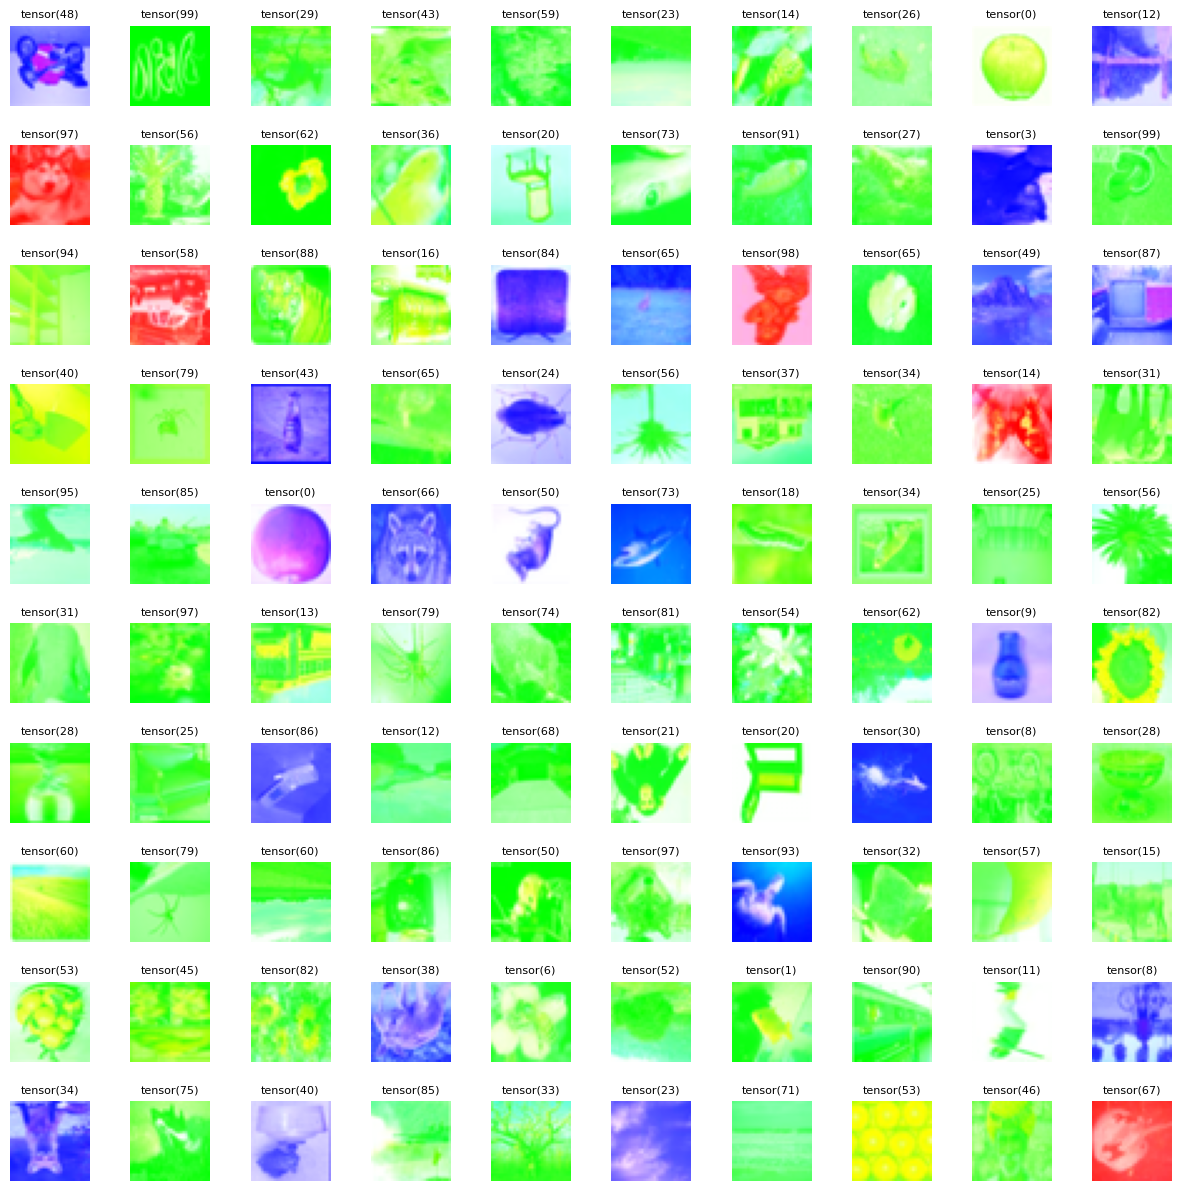

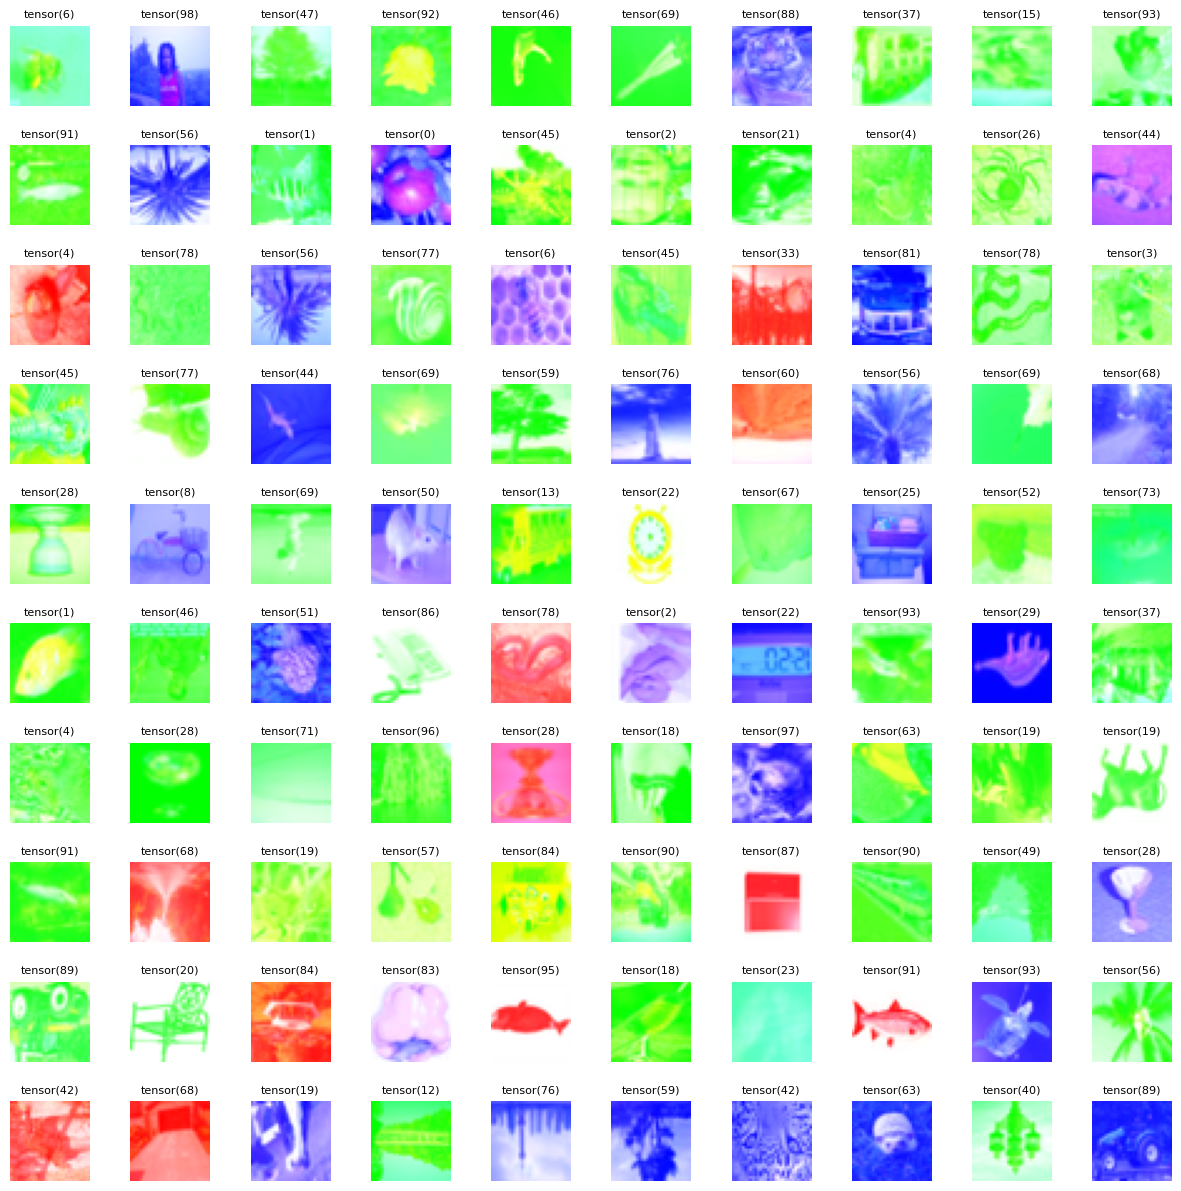

In [94]:
i=4

type_it(rearranged_data[i]['test_features'])
plot_first_100_images_with_labels(rearranged_data[i]['train_features'],rearranged_data[i]['train_labels'])
plot_first_100_images_with_labels(rearranged_data[i]['test_features'],rearranged_data[i]['test_labels'])
